In [1]:
import numpy as np 
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mobilenet-1-0-224-tf-no-toph5/mobilenet_1_0_224_tf_no_top.h5


In [2]:
!pip install gdown

In [3]:
import gdown

download_link = f'https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4'
gdown.download(download_link, 'dataset.zip', quiet=False)

Downloading...
From (uriginal): https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4
From (redirected): https://drive.google.com/uc?id=1FD6OKhqwygBZC_Xhyj3SVx0q0PbQPTx4&confirm=t&uuid=8d044afb-3f2e-4cef-9aab-b3ac0d078246
To: /kaggle/working/dataset.zip
100%|██████████| 88.4M/88.4M [00:00<00:00, 190MB/s]


'dataset.zip'

In [4]:
!unzip "/kaggle/working/dataset.zip"

Archive:  /kaggle/working/dataset.zip
replace dataset/test/1073.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


**preprocessing**

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import os

data = []
labels = []
IMG_SIZE = 224
data_path = '/kaggle/working/dataset/train/'

# Loop through class directories
for class_dir in os.listdir(data_path):
    class_path = os.path.join(data_path, class_dir)

    # Check if the item in the directory is a directory
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if os.path.isfile(img_path) and img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv.imread(img_path)
                if img is not None:
                    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                    img = cv.resize(img, (IMG_SIZE, IMG_SIZE))
                    data.append(img)
                    labels.append(class_dir)
                else:
                    print(f"Error loading image: {img_path}")
            else:
                print(f"Skipping non-image file: {img_path}")

print(len(data))
print(len(labels))
print(labels[0])

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


9900
9900
4


In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

le = LabelEncoder()
train_labels = le.fit_transform(labels)
train_labels = to_categorical(train_labels, len(np.unique(train_labels)))

# split the data into training and testing
(trainX, testX, trainY, testY) = train_test_split(np.array(data), np.array(train_labels), test_size=0.20, random_state=42)

# normalize the data
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

print(len(trainX))
print(len(testX))

7920
1980


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
train_gen = train_datagen.flow(trainX,trainY,batch_size=32)

print(len(train_gen))

248


In [8]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
print(unique_labels)
print(label_counts)

['1' '2' '3' '4' '5']
[1980 1980 1980 1980 1980]


**Plotting randomly selected images**

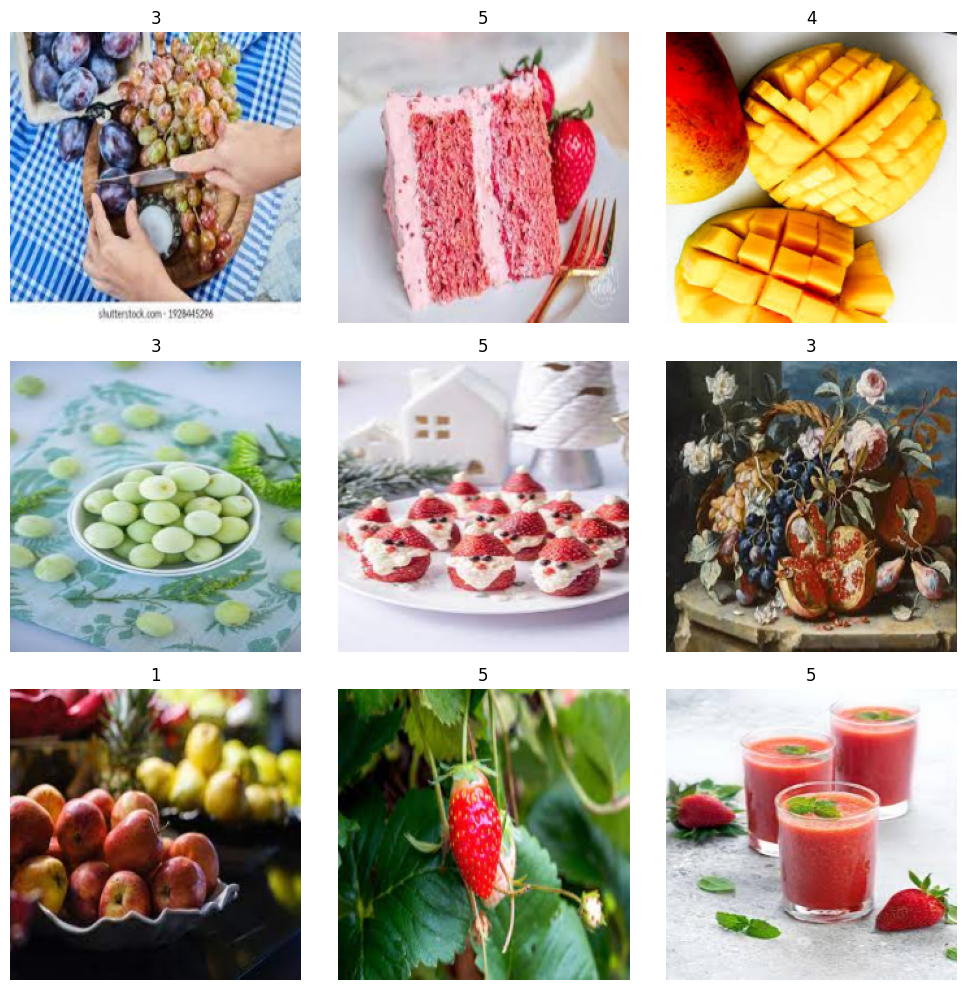

In [9]:
import random

random_indices = random.sample(range(len(data)), 9)
plt.figure(figsize=(10, 10))
for i, index in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(data[index])
    plt.title(labels[index])
    plt.axis('off')

plt.tight_layout()
plt.show()

**Implement Mobilenet Model**

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import *
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, DepthwiseConv2D, SeparableConv2D, GlobalAveragePooling2D, Dense
  
def Depthwise_Separable_Conv(strides_depthwise, padding_depthwise, filters_pointwise, layer):
    layer = tf.keras.layers.DepthwiseConv2D(kernel_size= (3,3), strides= strides_depthwise, padding= padding_depthwise, use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    
    layer = tf.keras.layers.Conv2D(filters= int(filters_pointwise), padding= 'same', kernel_size= (1,1), strides= (1,1), use_bias = False)(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    layer = tf.keras.layers.ReLU()(layer)
    return layer 
    

In [12]:
inputs = tf.keras.layers.Input(shape= (224,224,3))
layer = Conv2D(filters= 32, kernel_size=(3,3), strides= (2,2), padding= 'same', use_bias = False)(inputs)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
# Depth_Separable_Conv 1
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same',filters_pointwise= 64, layer = layer)
# Depth_Separable_Conv 2
layer = Depthwise_Separable_Conv(strides_depthwise= (2
                                                     ,2), padding_depthwise= 'same', filters_pointwise= 128, layer = layer)
# Depth_Separable_Conv 3
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 128, layer = layer)
# Depth_Separable_Conv 4
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 256, layer = layer)
# Depth_Separable_Conv 5
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 256, layer = layer)
# Depth_Separable_Conv 6
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
# Depth_Separable_Conv 7 - > 11
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
layer =Depthwise_Separable_Conv(strides_depthwise= (1,1), padding_depthwise= 'same', filters_pointwise= 512, layer = layer)
# Depth_Separable_Conv 12
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 1024, layer = layer)

# Depth_Separable_Conv 13
layer =Depthwise_Separable_Conv(strides_depthwise= (2,2), padding_depthwise= 'same', filters_pointwise= 1024, layer = layer)

model = Model(inputs, layer)

In [13]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, concatenate

model.load_weights("/kaggle/input/mobilenet-1-0-224-tf-no-toph5/mobilenet_1_0_224_tf_no_top.h5")

for layer in model.layers :
    layer.trainable = False 
    
# FC
cont_layers = model.output
cont_layers = Flatten()(cont_layers)
cont_layers = Dense(256, activation= 'relu')(cont_layers)
cont_layers = tf.keras.layers.BatchNormalization()(cont_layers)
cont_layers = Dropout(0.001)(cont_layers)
cont_layers = Dense(5, activation= 'softmax')(cont_layers)
model = Model(model.input, cont_layers)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      864       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      288       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128 

In [14]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = ModelCheckpoint('model.h5',monitor='val_loss',verbose=1,save_best_only=True,save_weights_only=False,mode='auto',period=1)
early = EarlyStopping(monitor='val_loss',min_delta=0,patience=60,verbose=1,mode='auto')
hist = model.fit(train_gen,epochs=200,validation_data=(testX,testY),callbacks=[checkpoint,early])

Epoch 1/200
248/248 [==============================] - ETA: 0s - loss: 0.7555 - accuracy: 0.7499
Epoch 1: val_loss improved from inf to 0.50053, saving model to model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


248/248 [==============================] - 98s 344ms/step - loss: 0.7555 - accuracy: 0.7499 - val_loss: 0.5005 - val_accuracy: 0.8323
Epoch 2/200
248/248 [==============================] - ETA: 0s - loss: 0.5290 - accuracy: 0.8096
Epoch 2: val_loss improved from 0.50053 to 0.48404, saving model to model.h5
248/248 [==============================] - 80s 321ms/step - loss: 0.5290 - accuracy: 0.8096 - val_loss: 0.4840 - val_accuracy: 0.8328
Epoch 3/200
248/248 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8263
Epoch 3: val_loss improved from 0.48404 to 0.45301, saving model to model.h5
248/248 [==============================] - 79s 319ms/step - loss: 0.4828 - accuracy: 0.8263 - val_loss: 0.4530 - val_accuracy: 0.8404
Epoch 4/200
248/248 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.8309
Epoch 4: val_loss improved from 0.45301 to 0.43947, saving model to model.h5
248/248 [==============================] - 80s 321ms/step - loss: 0.4670 - a

In [15]:
from tensorflow.keras.models import load_model

loaded_model = load_model('model.h5')

validation_accuracy = loaded_model.evaluate(testX,testY)

print(f'Validation Accuracy: {validation_accuracy}')

62/62 [==============================] - 2s 28ms/step - loss: 0.3855 - accuracy: 0.8677
Validation Accuracy: [0.38547632098197937, 0.8676767945289612]


**plot Confusion matrix**

62/62 [==============================] - 2s 27ms/step


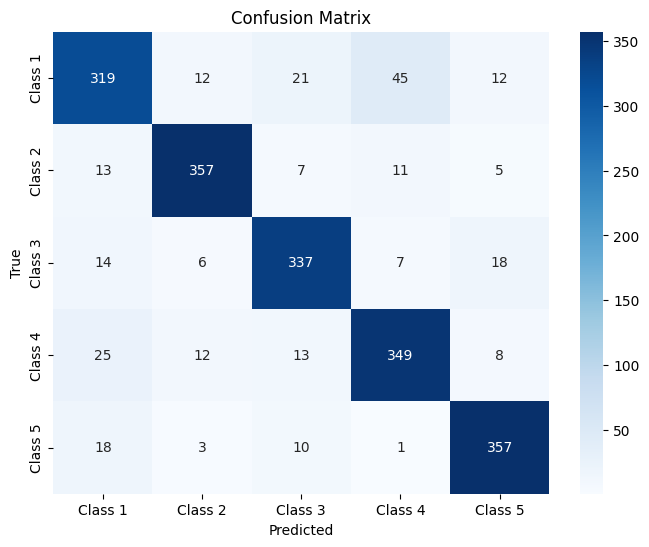

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Generate predictions
y_pred = model.predict(testX)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(testY, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
class_names = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Classification report**

In [23]:
# Classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

     Class 1       0.82      0.78      0.80       409
     Class 2       0.92      0.91      0.91       393
     Class 3       0.87      0.88      0.88       382
     Class 4       0.85      0.86      0.85       407
     Class 5       0.89      0.92      0.90       389

    accuracy                           0.87      1980
   macro avg       0.87      0.87      0.87      1980
weighted avg       0.87      0.87      0.87      1980



**plot Learning curve**

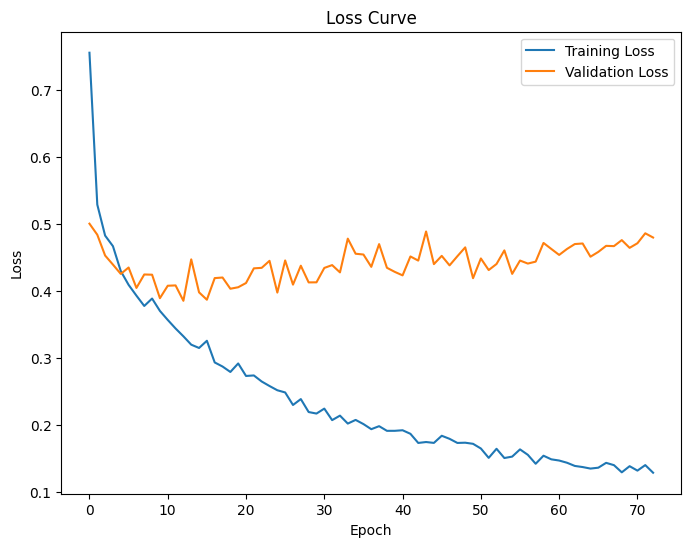

In [26]:
import matplotlib.pyplot as plt

# Access the training history
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

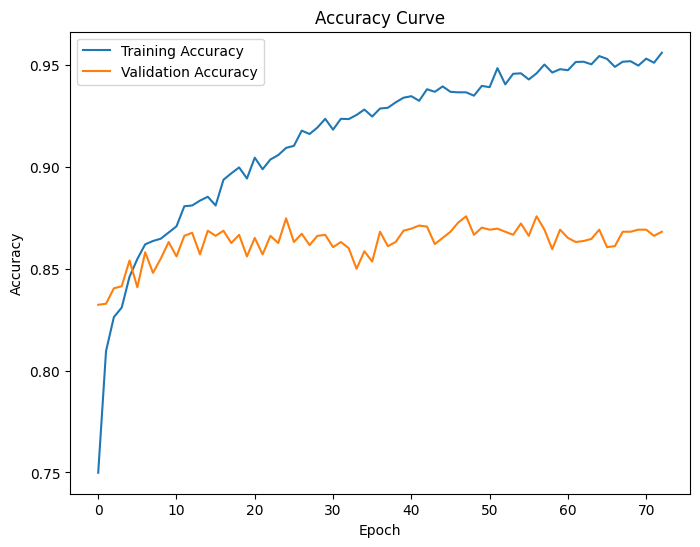

In [27]:
# Plot the accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [28]:
test_data = []
for i in os.listdir('/kaggle/working/dataset/test'):
    img = cv.imread('/kaggle/working/dataset/test/'+i)
    img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
    img = cv.resize(img,(IMG_SIZE,IMG_SIZE))
    test_data.append(np.array(img))
test_data = np.array(test_data)
test_data = test_data/255.0

print(len(test_data))

100


In [29]:
pred = loaded_model.predict(test_data)
pred = np.argmax(pred,axis=1)
print(pred)

4/4 [==============================] - 0s 32ms/step
[0 4 3 3 4 3 1 3 1 3 0 0 1 1 2 4 4 1 4 4 0 1 2 3 4 4 3 4 3 1 3 0 1 2 1 2 0
 3 3 0 4 2 3 1 1 1 2 0 0 2 0 4 0 3 0 2 4 2 3 1 4 2 2 0 2 1 2 4 0 1 2 4 0 4
 1 3 1 3 3 3 1 2 1 3 1 4 1 0 3 0 0 2 2 1 2 0 1 2 2 3]


In [30]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

pred = model.predict(test_data)
pred_labels = np.argmax(pred, axis=1)

adjusted_pred_labels = pred_labels + 1

image_names = [os.path.splitext(file)[0] for file in os.listdir('/kaggle/working/dataset/test')]
df = pd.DataFrame({
    'image_id': image_names,
    'label': adjusted_pred_labels,
})

df.to_csv('/kaggle/working/Image Classification.csv', index=False)
df

4/4 [==============================] - 0s 37ms/step


image_id  label
0        27      1
1       598      5
2      1718      4
3        58      4
4       122      5
..      ...    ...
95       12      1
96     1266      2
97     1073      3
98     1222      3
99     1287      4

[100 rows x 2 columns]

**Visualize some of test images with predicted fruit names**

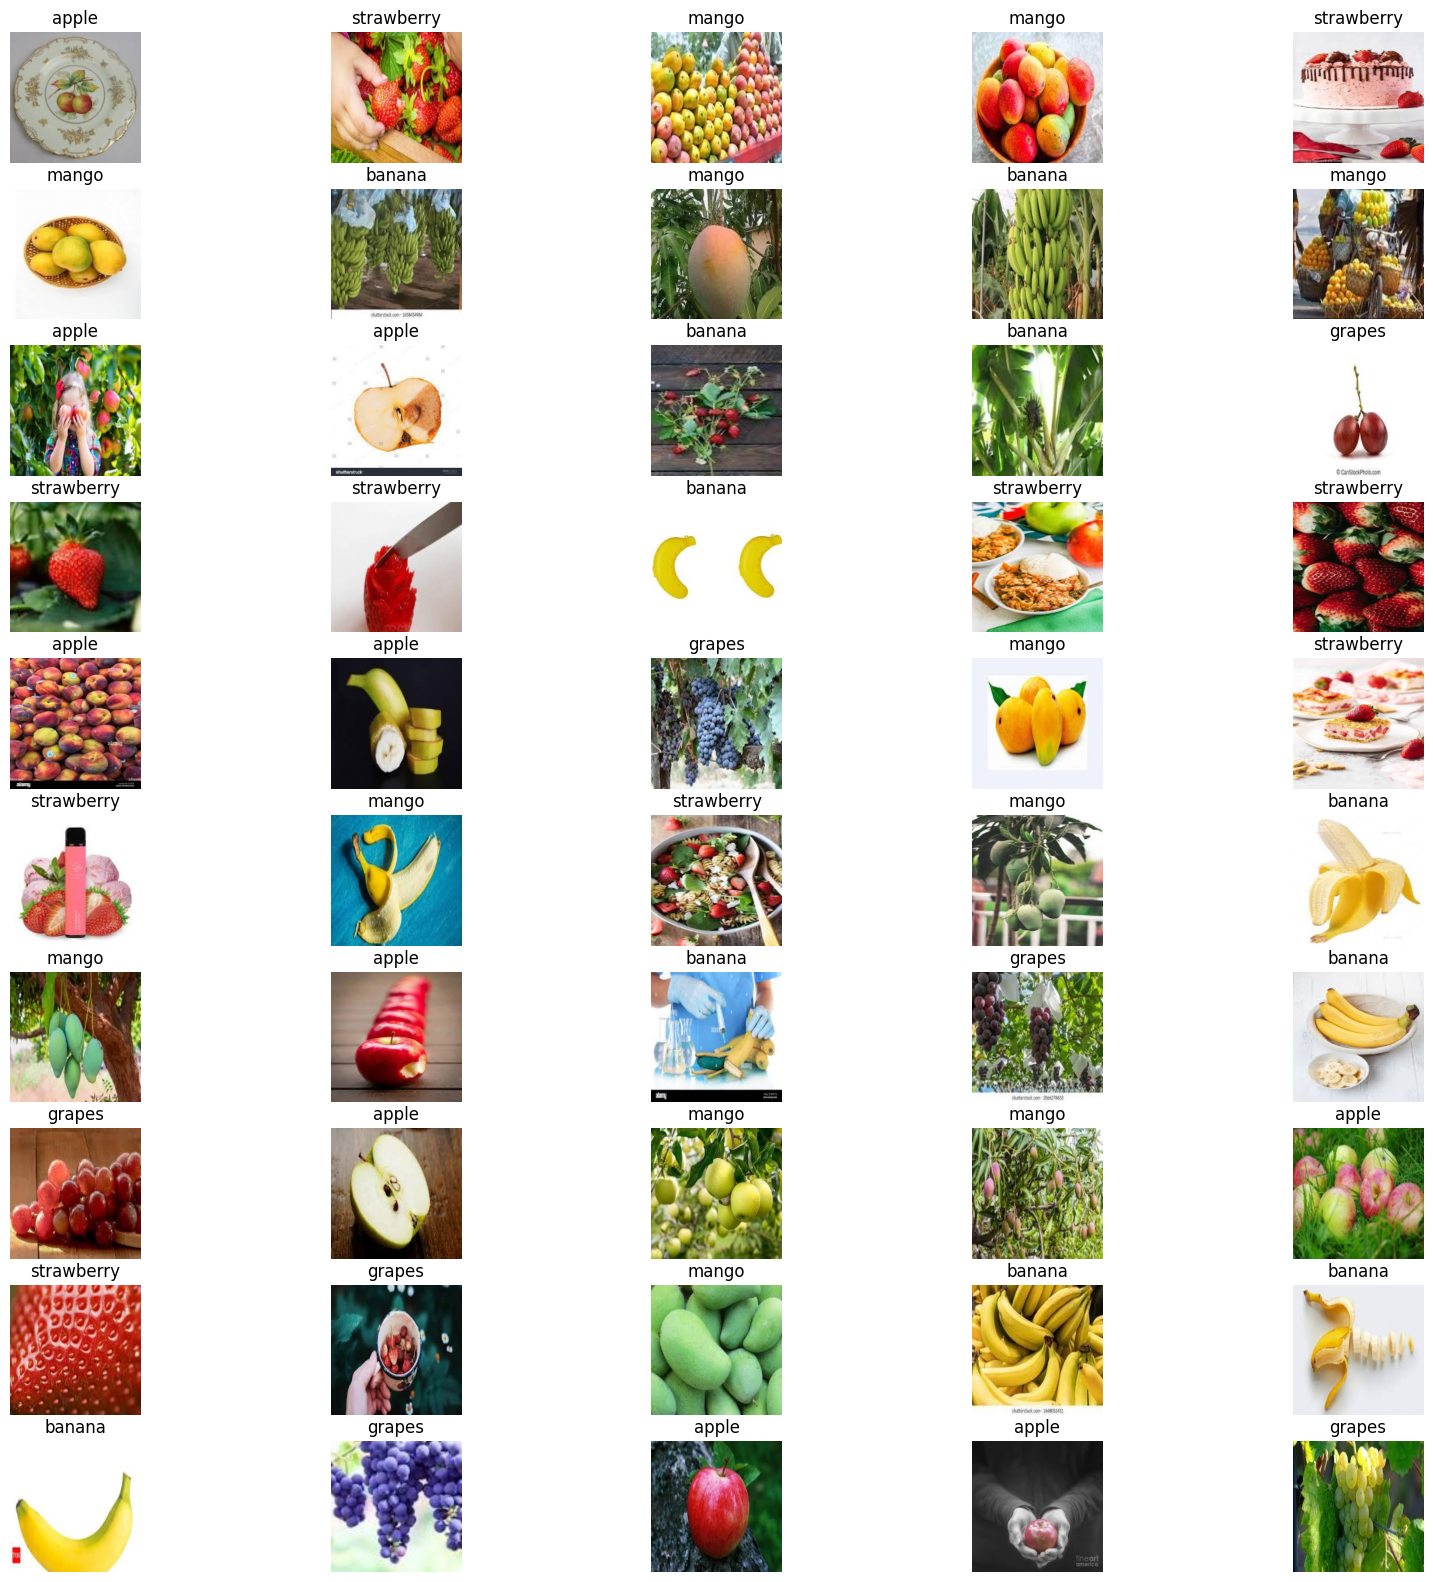

In [32]:
label_to_fruit = {1: 'apple', 2: 'banana', 3: 'grapes', 4: 'mango', 5: 'strawberry'}

pred_fruit_names = [label_to_fruit[label] for label in adjusted_pred_labels]

plt.figure(figsize=(20, 20))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.imshow(test_data[i])
    plt.title(pred_fruit_names[i])
    plt.axis('off')
plt.show()